In [1]:
import libsmartchess as libsc
import torch
import numpy as np
import seaborn as sns

In [2]:
import igraph as ig

def _traverse(node, parent_vertex, move_path, graph, start_depth, max_depth):
    if max_depth >= 0 and node["depth"] >= max_depth:
        return
    
    num_act = node["num_act"]
    q = node["q"]
    args = {
        "depth": node["depth"],
        "num_act": num_act,
        "size": int(num_act)+40,
    }
    move, turn = node["step"]

    args["turn"] = turn
    
    if move is not None:
        args["label"] = f"{move} / {num_act}\n{q:.2f}"
        args["move"] = move
    else:
        args["label"] = f"_ / {num_act}\n{q:.2f}"
        args["name"] = "root"

    if move_path and move == move_path[0]:
        args["color"] = (0, 1, 0)
        move_path = move_path[1:]
    else:
        # only show nodes on the path before reaching the start_depth
        if node["depth"] <= start_depth:
            return
        
        move_path = None
    
    v = graph.add_vertex(**args)
        
    if parent_vertex:
        graph.add_edge(source=v, target=parent_vertex)

    for c in node["children"]:
        _traverse(c, v, move_path, graph, start_depth, max_depth)

def to_graph(tree, move_path, start_depth=0, max_depth=-1):
    graph = ig.Graph()
    
    if start_depth > len(move_path):
        start_depth = len(move_path)
        
    _traverse(tree, None, move_path, graph, start_depth, max_depth)
    return graph

In [3]:
#checkpoint = "../runs/010/tb_logs/chess/version_13/step:101-3.527-0.393.pt"
checkpoint = "../runs/014/tb_logs/chess/version_0/last.pt"
# checkpoint = "../runs/000/last-bf16.pt"

In [4]:
g = libsc.play_new(checkpoint)

n = 11
turn = n % 2 == 0
for i in range(n):
    libsc.play_mcts(g, 200, 2.5)
    libsc.play_step(g, 0)

steps, distr, outcome = libsc.play_inference(g, True)

amdgpu.ids: No such file or directory


In [5]:
move_distr = np.array(distr)[[libsc.encode_move(turn, s[0]) for s in steps]]
move_distr_test = np.array(libsc.play_inference(g, False)[1])
np.testing.assert_almost_equal(move_distr, move_distr_test, decimal=2)

In [6]:
outcome

-0.2578125

<Axes: >

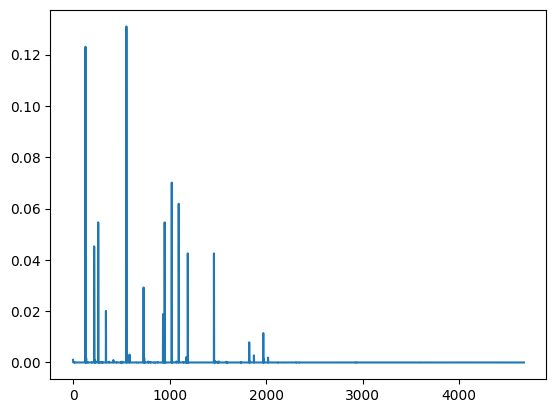

In [7]:
sns.lineplot(np.array(distr))

In [8]:
g = libsc.play_new(checkpoint)
for i in range(11):
    libsc.play_mcts(g, 200, 2.5)
    libsc.play_step(g, 0)
tree = libsc.play_dump_search_tree(g)
_,m,_,_ = libsc.play_inspect(g)
move_path = [str(s) for s in m] + [None]
move_path.reverse()

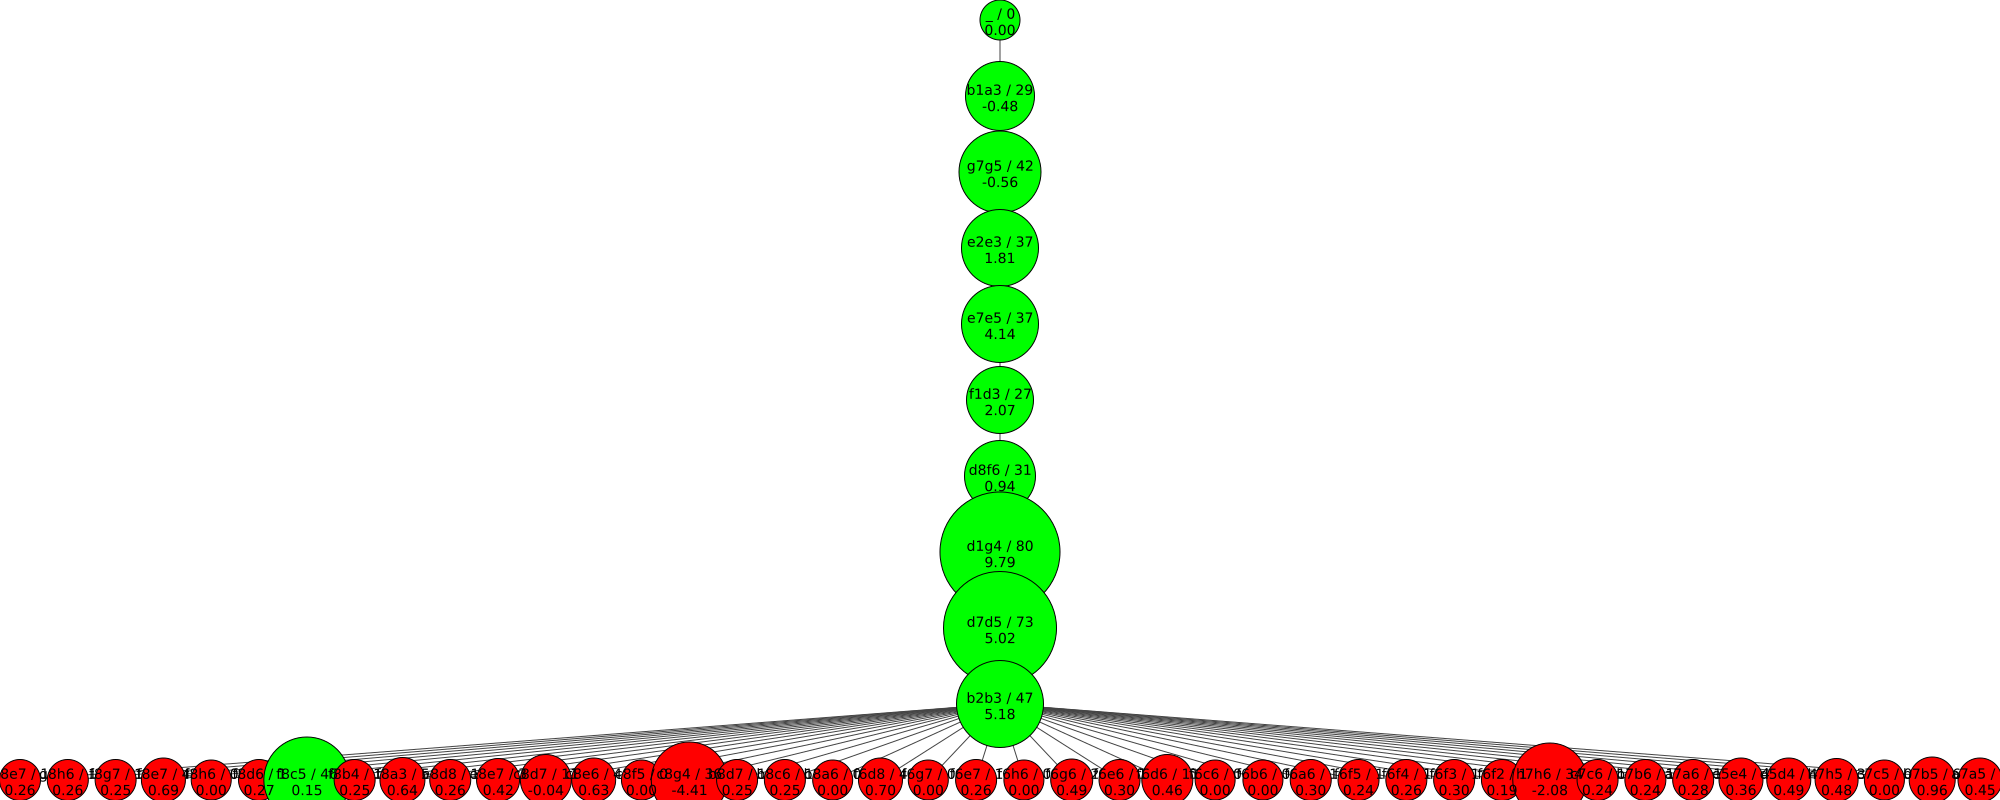

In [9]:
s = 9
graph = to_graph(tree, move_path, s, s+2)
layout = graph.layout_reingold_tilford(root=["root"])
ig.plot(graph, "graph.svg", layout=layout, bbox=(2000, 800))

In [33]:
import chess

def encode_steps(path):
    assert path[0] is None
    path = path[1:]

    steps = []
    board = chess.Board()
    for m in path:
        m = chess.Move.from_uci(m)
        num_act = {m: 0 for m in board.legal_moves}
        num_act[m] = 1
        steps.append((m, list(num_act.items())))
        board.push(m)

    return libsc.encode_steps(steps, False)
    
enc = encode_steps(move_path)

In [14]:
def check_board_enc(enc):
    cnt = 0
    for i in range(0, 112, 14):
        if enc[0][:, :, i:i+14].any():
            cnt += 1
    return cnt

check_board_enc(enc[0])

1

In [15]:
import torch
import numpy as np

def predict(enc_step):
    boards, meta, dist, mi = enc_step
    inp = np.concatenate((boards, meta), axis=-1).astype(np.float32)
    inp = inp.transpose(2,0,1)[None, ...]
    model = torch.jit.load(checkpoint)
    distr, outcome = model(torch.from_numpy(inp).bfloat16().cuda())
    distr = np.exp(distr.float().cpu().numpy()[0])
    outcome = outcome.item()

    distr = distr[mi]
    distr = distr / distr.sum()
    return distr, outcome

In [16]:
distr, _ = predict(enc[0])
order = np.argsort(distr)[::-1]
distr[order][:5]

array([0.5652862 , 0.0564099 , 0.04824995, 0.04676545, 0.03019404],
      dtype=float32)

In [17]:
v = 751
rank, file, typ = v // (8 * 73), v % (8 * 73) // 73, v % (8 * 73) % 73
chess.FILE_NAMES[file] + chess.RANK_NAMES[rank], typ

('c2', 21)

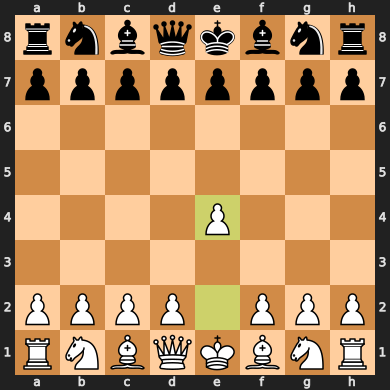

In [18]:
def get_board(moves):
    # root move is None
    if moves[0] is None:
        moves = moves[1:]

    b = chess.Board()
    for m in moves:
        m = chess.Move.from_uci(m)
        b.push(m)

    return b

b = get_board(move_path[:5])
b

In [19]:
def descend(tree, path):
    assert path[0] is None
    for m in path[1:]:
        for c in tree["children"]:
            if c["step"][0] == m:
                tree = c
                break
        else:
            raise RuntimeError(f"step {m} not found")
    return tree

In [20]:
noi = descend(tree, move_path[:1])
qs = [n["q"] for n in noi["children"]]
na = [n["num_act"] for n in noi["children"]]
sn = [n["step"][0] for n in noi["children"]]
turn_tbl = {"White": 1, "Black": 0}

In [22]:
np.array(list(zip(sn, qs, na, distr)))

array([['g1h3', '0.012573242', '2', '0.011824156'],
       ['g1f3', '0.2033081', '9', '0.048249945'],
       ['b1c3', '-0.23980713', '2', '0.016161706'],
       ['b1a3', '0.018859863', '3', '0.025031742'],
       ['h2h3', '0.014587402', '6', '0.010434782'],
       ['g2g3', '0.07220459', '8', '0.029265068'],
       ['f2f3', '0.9614868', '10', '0.027491989'],
       ['e2e3', '-0.13067627', '6', '0.0564099'],
       ['d2d3', '1.1412964', '11', '0.030194044'],
       ['c2c3', '-0.005859375', '1', '0.010113738'],
       ['b2b3', '-0.09692383', '5', '0.046765447'],
       ['a2a3', '0.018859863', '3', '0.0098025715'],
       ['h2h4', '0.031433105', '5', '0.019494738'],
       ['g2g4', '0.022705078', '4', '0.022791658'],
       ['f2f4', '0.0', '0', '0.0050855065'],
       ['e2e4', '2.9828033', '109', '0.5652862'],
       ['d2d4', '-0.10223389', '4', '0.012586749'],
       ['c2c4', '0.018859863', '3', '0.024261594'],
       ['b2b4', '0.006286621', '1', '0.012586749'],
       ['a2a4', '-0.603759

In [23]:
noi["step"][1]

'White'

In [36]:
import math
def uct(q, n_act, total_n_act, cpuct, prior):
    avg_rwd = q / (n_act + 1e-4)
    exp = math.sqrt(total_n_act) / (1 + n_act) * cpuct * prior
    return avg_rwd +  exp

In [37]:
tn = sum(na)
{m: uct(q, n, tn, 0.5, p) for (m, q, n, p) in zip(sn, qs, na, distr)}

{'g1h3': 0.03408634820110331,
 'g1f3': 0.056621999682843246,
 'b1c3': -0.08189941616564256,
 'b1a3': 0.0504259328771067,
 'h2h3': 0.012945530043109624,
 'g2g3': 0.031960716173590115,
 'f2f3': 0.11377600147447485,
 'e2e3': 0.035060952784773045,
 'd2d3': 0.12150075032284095,
 'c2c3': 0.02980916721084987,
 'b2b3': 0.03559127244129269,
 'a2a3': 0.023571697458210906,
 'h2h4': 0.02920375593856294,
 'g2g4': 0.03782771722254792,
 'f2f4': 0.03586994859316439,
 'e2e4': 0.06361215844822612,
 'd2d4': -0.007802038831614316,
 'c2c4': 0.0490678987586759,
 'b2b4': 0.050675479207127,
 'a2a4': -0.07200085583564761}

In [87]:
tn

4

In [68]:
1 / 0.002165909536415711

461.69980010100767

In [30]:
uct(0, 0, 0, 2.5, 0.041539043)

(0.0, 0.0)